In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import scipy.sparse as sp

In [14]:
# --- Preparamos la función que construye y aplica el pipeline ---



def prepare_pipeline_and_data(df_input, target_col='Churn', id_col='customerID'):
    """Construye un pipeline que realiza:
       - conversión de TotalCharges a numérico y eliminación de filas inválidas
       - imputación de TotalCharges si hace falta (mediana)
       - log-transform de TotalCharges
       - escalado de variables numéricas (tenure, MonthlyCharges, TotalCharges_log)
       - one-hot encoding de variables categóricas
       - deja SeniorCitizen tal cual (int) como passthrough
       Retorna: X_df (DataFrame procesado), y (Series), fitted pipeline
    """
    # Copia para no modificar el original
    df2 = df_input.copy()

    # Convertir TotalCharges y, si existen NaNs (posibles por re-ejecuciones), imputar por mediana
    df2['TotalCharges'] = pd.to_numeric(df2['TotalCharges'], errors='coerce')
    if df2['TotalCharges'].isna().sum() > 0:
        df2['TotalCharges'].fillna(df2['TotalCharges'].median(), inplace=True)

    # Convertir SeniorCitizen a int
    if 'SeniorCitizen' in df2.columns:
        df2['SeniorCitizen'] = df2['SeniorCitizen'].astype(int)

    # Preparar y
    y = df2[target_col].map({'Yes': 1, 'No': 0}) if df2[target_col].dtype == 'object' else df2[target_col]

    # Eliminar id y target para X
    X = df2.drop(columns=[target_col])
    if id_col in X.columns:
        X = X.drop(columns=[id_col])

    # Definir columnas numéricas a escalar y categóricas a one-hot
    numeric_basic = [c for c in ['tenure', 'MonthlyCharges'] if c in X.columns]
    numeric_total = ['TotalCharges'] if 'TotalCharges' in X.columns else []

    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    # Transformador para TotalCharges: log1p then scaler
    total_transformer = Pipeline(steps=[
        ('log', FunctionTransformer(np.log1p, validate=False)),
        ('scaler', StandardScaler())
    ])

    # Transformador para other numerics
    numeric_transformer = StandardScaler()

    # Categorical transformer
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    transformers = []
    if numeric_basic:
        transformers.append(('num', numeric_transformer, numeric_basic))
    if numeric_total:
        transformers.append(('total', total_transformer, numeric_total))
    if categorical_features:
        transformers.append(('cat', categorical_transformer, categorical_features))

    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    # Ajustar y transformar
    X_trans = pipeline.fit_transform(X)
    if sp.issparse(X_trans):
        X_trans = X_trans.toarray()

    # Obtener nombres de columnas resultantes
    try:
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    except Exception:
        num_names = numeric_basic
        try:
            cat_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
        except Exception:
            cat_names = []
            for c in categorical_features:
                unique_vals = X[c].astype(str).unique().tolist()
                cat_names.extend([f"{c}_{v}" for v in unique_vals])
        total_names = ['TotalCharges_log'] if numeric_total else []
        passthrough_names = [c for c in X.columns if c not in numeric_basic + numeric_total + categorical_features]
        feature_names = list(num_names) + total_names + list(cat_names) + passthrough_names

    X_df = pd.DataFrame(X_trans, columns=feature_names)
    X_df.index = df2.index
    y.index = df2.index
    return X_df, y, pipeline


# Carga y Preparación de Datos
Cargaremos los datos procesados y los dividiremos en conjuntos de entrenamiento y prueba.

In [15]:
# Cargar datos
df = pd.read_csv('data.csv')

# Procesar datos usando el pipeline
X_processed, y, pipeline = prepare_pipeline_and_data(df)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Dimensiones de los conjuntos de datos:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Dimensiones de los conjuntos de datos:
X_train: (5634, 45)
X_test: (1409, 45)
y_train: (5634,)
y_test: (1409,)


C:\Users\locos\AppData\Local\Temp\ipykernel_19320\3291261620.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['TotalCharges'].fillna(df2['TotalCharges'].median(), inplace=True)


# Implementación de Modelos Base
Implementaremos los siguientes modelos:
1. Random Forest
2. XGBoost
3. CatBoost
4. LightGBM

Primero los implementaremos con parámetros básicos para tener una línea base de rendimiento.

## GridSearch helper and parameter grids
A continuación se definen grids de ejemplo (moderados) para cada modelo y una función reutilizable `run_grid_search` que ejecuta `GridSearchCV` y devuelve el mejor estimador y un DataFrame con los resultados.

Nota: los grids están intencionadamente compactos; amplía las listas según necesites (o usa RandomizedSearchCV si quieres explorar más combinaciones rápidamente). No ejecutes búsquedas exhaustivas en el notebook a menos que quieras esperar el tiempo de cómputo.

In [16]:
# Definir grids moderados (ajusta según conveniencia)
param_grids = {
    'RandomForest': {
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'criterion': ['gini', 'entropy']
    },
    'XGBoost': {
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 1, 5],
        'min_child_weight': [1, 3, 5],
        'reg_alpha': [0, 0.5],
        'reg_lambda': [1, 1.5],
        'scale_pos_weight': [1]
    },
    'CatBoost': {
        'l2_leaf_reg': [1, 3, 5],
        'bagging_temperature': [0, 1, 2],
        'border_count': [32, 64],
        'random_strength': [0, 1, 2],
        'one_hot_max_size': [2, 10],
        'subsample': [0.6, 0.8, 1.0]
    },
    'LightGBM': {
        'min_child_samples': [5, 10, 20],
        'min_child_weight': [1e-3, 1, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.5],
        'reg_lambda': [0, 1.0],
        'max_bin': [255, 300]
    }
}

# Fábrica de estimadores con parámetros base seguros
def get_estimator_by_name(name):
    name = name.lower()
    if name == 'randomforest':
        return RandomForestClassifier(random_state=42, n_jobs=-1)
    elif name == 'xgboost':
        # suppress label encoder warnings and set eval_metric for sklearn wrapper
        return xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    elif name == 'catboost':
        # verbose=0 to reduce output
        return cb.CatBoostClassifier(random_state=42, verbose=0)
    elif name == 'lightgbm':
        return lgb.LGBMClassifier(random_state=42, n_jobs=-1)
    else:
        raise ValueError(f"Estimador desconocido: {name}")


# Función reutilizable para GridSearchCV
from sklearn.model_selection import GridSearchCV
import pandas as pd

def run_grid_search(name, X_train, y_train, param_grid=None, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1):
    """Ejecuta GridSearchCV para el modelo indicado por `name`.
    name: 'RandomForest' | 'XGBoost' | 'CatBoost' | 'LightGBM'
    param_grid: si None, usa los grids por defecto en param_grids
    Retorna: best_estimator, best_score, results_df
    """
    est_name = name
    if param_grid is None:
        if name not in param_grids:
            raise ValueError(f"No hay grid por defecto para: {name}")
        param_grid = param_grids[name]

    estimator = get_estimator_by_name(name)

    # Para CatBoost con sklearn wrapper, GridSearchCV funciona igual
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        return_train_score=True
    )

    # Fit
    gs.fit(X_train, y_train)

    # Resultados
    best = gs.best_estimator_
    best_score = gs.best_score_
    results_df = pd.DataFrame(gs.cv_results_)

    print(f"GridSearch completado para {name} - best_score={best_score:.4f}")
    print("Mejores parámetros:", gs.best_params_)

    return best, best_score, results_df


# Ejemplo de uso (comentado):
# best_rf, best_score_rf, rf_results = run_grid_search('RandomForest', X_train, y_train, cv=3, scoring='roc_auc')
# Nota: descomenta y ajusta el grid si quieres ejecutar la búsqueda.


In [17]:
# Función para evaluar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Hacer predicciones
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calcular métricas
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }
    
    return metrics

# Inicializar los modelos base
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=False),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

# Entrenar y evaluar cada modelo
results = {}
for name, model in models.items():
    print(f"\nEntrenando {name}...")
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)
    
# Mostrar resultados
results_df = pd.DataFrame(results).round(4)
print("\nResultados de los modelos base:")
print(results_df)


Entrenando RandomForest...

Entrenando XGBoost...

Entrenando CatBoost...

Entrenando XGBoost...

Entrenando CatBoost...

Entrenando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328

Resultados de los modelos base:
           RandomForest  XGBoost  CatBoost  LightGBM
accuracy         0.7800   0.7850    0.7977    0.7928
precision        0.6081   0.6060    0.6422    0.6349
recall           0.4813   0.5428    0.5374    0.5160
f1               0.5373   0.5726    0.5

Entrenando y evaluando RandomForest...
Entrenando y evaluando XGBoost...
Entrenando y evaluando XGBoost...


c:\COSAS IVAN JR PC\Documentos\Machine_Learning\MiniProyecto-5\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:51:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Entrenando y evaluando CatBoost...
Entrenando y evaluando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
Entrenando y evaluando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can 

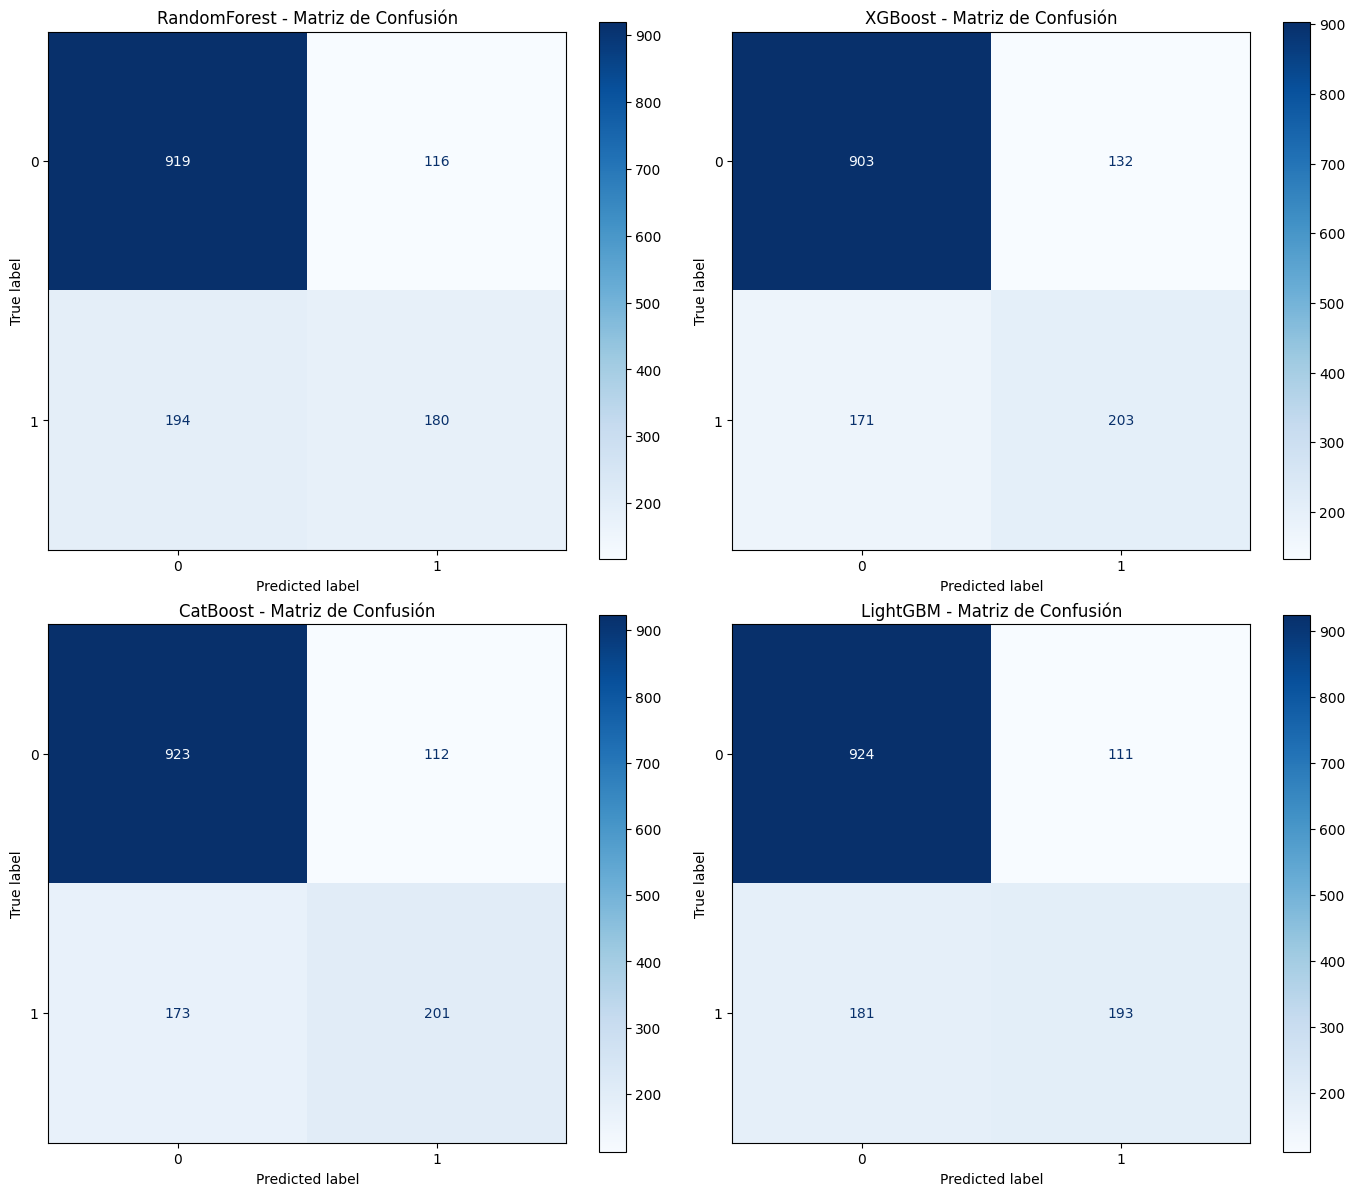

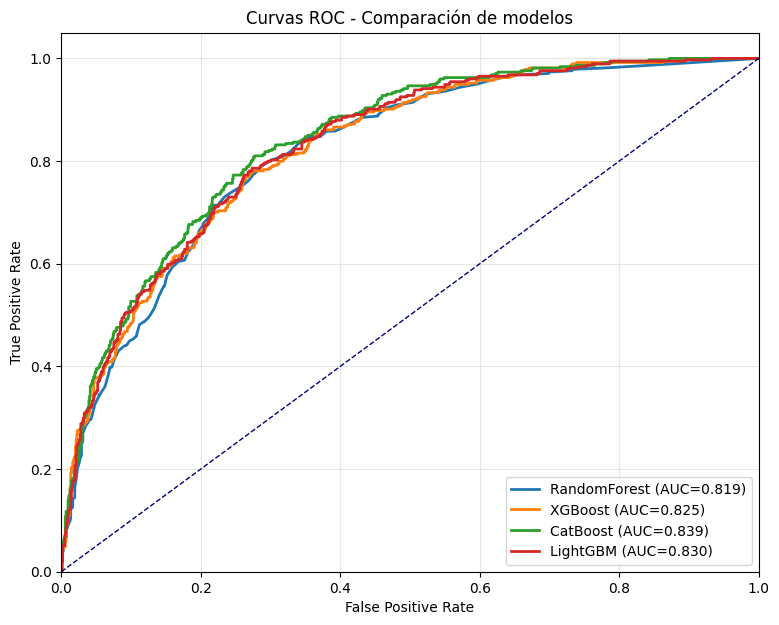


Resumen de métricas:
              accuracy  precision  recall      f1  roc_auc
RandomForest    0.7800     0.6081  0.4813  0.5373   0.8189
XGBoost         0.7850     0.6060  0.5428  0.5726   0.8254
CatBoost        0.7977     0.6422  0.5374  0.5852   0.8394
LightGBM        0.7928     0.6349  0.5160  0.5693   0.8296


In [18]:
# Dibujar matrices de confusión y curvas ROC para cada modelo
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

model_names = ['RandomForest', 'XGBoost', 'CatBoost', 'LightGBM']

fitted_models = {}
metrics_summary = {}

# Ajustar cada modelo y recopilar predicciones/probabilidades
for name in model_names:
    print(f"Entrenando y evaluando {name}...")
    est = get_estimator_by_name(name)
    est.fit(X_train, y_train)

    # Predecir clases y probabilidades (o scores)
    y_pred = est.predict(X_test)
    try:
        y_score = est.predict_proba(X_test)[:, 1]
    except Exception:
        # si no hay predict_proba, intentar decision_function
        try:
            y_score = est.decision_function(X_test)
        except Exception:
            y_score = y_pred

    # Guardar modelo y métricas
    fitted_models[name] = est
    metrics_summary[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_score) if len(pd.unique(y_test)) > 1 else float('nan')
    }

# Matrices de confusión en 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()
for ax, name in zip(axes, model_names):
    est = fitted_models[name]
    y_pred = est.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', normalize=None)
    ax.set_title(f"{name} - Matriz de Confusión")
plt.tight_layout()
plt.show()

# Curvas ROC superpuestas
plt.figure(figsize=(9, 7))
for name in model_names:
    est = fitted_models[name]
    try:
        y_score = est.predict_proba(X_test)[:, 1]
    except Exception:
        try:
            y_score = est.decision_function(X_test)
        except Exception:
            y_score = est.predict(X_test)

    # Algunas defensas por si y_score no es numérico continuo
    try:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc_val = roc_auc_score(y_test, y_score)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.3f})")
    except Exception as e:
        print(f"No se pudo calcular ROC para {name}: {e}")

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC - Comparación de modelos')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Mostrar tabla resumen de métricas
metrics_df = pd.DataFrame(metrics_summary).T.round(4)
print('\nResumen de métricas:')
print(metrics_df)

# Guardar modelos ajustados por si se quieren reutilizar más adelante
# (Opcional) Puedes descomentar para persistir los modelos:
# import joblib
# for name, m in fitted_models.items():
#     joblib.dump(m, f"{name}_fitted.pkl")


In [ ]:
# Extraer e imprimir las 10 features más importantes por modelo y graficarlas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

model_names = ['RandomForest', 'XGBoost', 'CatBoost', 'LightGBM']

# Helper para obtener importancias
def get_feature_importances(estimator, feature_names):
    n = len(feature_names)
    # 1) atributo estándar
    if hasattr(estimator, 'feature_importances_'):
        imp = np.array(estimator.feature_importances_)
        return pd.Series(imp, index=feature_names)

    # 2) CatBoost-like get_feature_importance
    if hasattr(estimator, 'get_feature_importance'):
        try:
            imp = np.array(estimator.get_feature_importance())
            # asegúrate de longitud
            if imp.shape[0] == n:
                return pd.Series(imp, index=feature_names)
        except Exception:
            pass

    # 3) XGBoost booster score (f0, f1, ...)
    if hasattr(estimator, 'get_booster'):
        try:
            score_dict = estimator.get_booster().get_score(importance_type='gain')
            imp = np.zeros(n, dtype=float)
            for k, v in score_dict.items():
                if k.startswith('f'):
                    idx = int(k[1:])
                    if idx < n:
                        imp[idx] = v
            return pd.Series(imp, index=feature_names)
        except Exception:
            pass

    # Fallback: zeros
    return pd.Series(np.zeros(n), index=feature_names)

# Plot top 10 features for each model in 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for ax, name in zip(axes, model_names):
    est = fitted_models.get(name)
    if est is None:
        ax.set_title(f"{name} - no entrenado")
        continue

    fi = get_feature_importances(est, X_train.columns)
    fi_top = fi.sort_values(ascending=False).head(10)

    # plot horizontal bar with descending order (largest arriba)
    fi_top.sort_values().plot(kind='barh', ax=ax, color='C0')
    ax.set_title(f"{name} - Top 10 Features")
    ax.set_xlabel('Importance')
    ax.tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()

# También devolver tables de las top10 en caso que quieras inspeccionar
top10_tables = {name: get_feature_importances(fitted_models[name], X_train.columns).sort_values(ascending=False).head(10) if name in fitted_models else None for name in model_names}

for name, table in top10_tables.items():
    print(f"\nTop 10 features - {name}:")
    if table is None:
        print('No hay modelo entrenado')
    else:
        print(table.round(6))
